In [45]:
import os
import cv2
import random
import numpy as np
import glob

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from PIL import Image as PILImage
from PIL.ExifTags import TAGS

from IPython.display import display

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import Sequence

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

from keras.layers import Layer

from sklearn.preprocessing import normalize

from annoy import AnnoyIndex

In [46]:
IMAGE_SIZE = (256, 256)

In [47]:
def imshow(a, size=1.0):
    # Clip and convert the image to uint8
    a = a.clip(0, 255).astype("uint8")
    
    # Resize the image if a size factor is provided
    if size != 1.0:
        new_dim = (int(a.shape[1] * size), int(a.shape[0] * size))
        a = cv2.resize(a, new_dim, interpolation=cv2.INTER_AREA)
    
    
    # Display the image
    display(PILImage.fromarray(a))

In [48]:
def read_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, IMAGE_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [49]:
data_folder = "Data/00*"
image_files = glob.glob(os.path.join(data_folder, "*.jpg"), recursive=True)

In [50]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add a Global Average Pooling layer to get 1D embeddings
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Create the model for embedding extraction
embedding_model = Model(inputs=base_model.input, outputs=x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


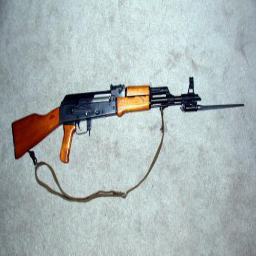

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


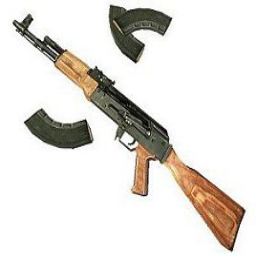

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


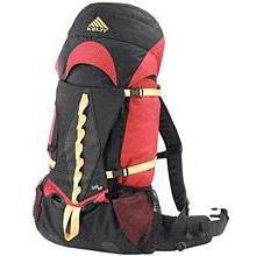

Distance between image 1 and image 2: 0.9760912
Distance between image 1 and image 3: 1.1438463


In [51]:
img_1 = read_image(image_files[0])
emb_1 = embedding_model.predict(np.expand_dims(img_1, axis=0))[0]
emb_1 = normalize(emb_1.reshape(1, -1))[0]
imshow(img_1)

img_2 = read_image(image_files[1])
emb_2 = embedding_model.predict(np.expand_dims(img_2, axis=0))[0]
emb_2 = normalize(emb_2.reshape(1, -1))[0]
imshow(img_2)

img_3 = read_image(image_files[342])
emb_3 = embedding_model.predict(np.expand_dims(img_3, axis=0))[0]
emb_3 = normalize(emb_3.reshape(1, -1))[0]
imshow(img_3)

dist_1_2 = np.linalg.norm(emb_1 - emb_2)
dist_1_3 = np.linalg.norm(emb_1 - emb_3)

print("Distance between image 1 and image 2:", dist_1_2)
print("Distance between image 1 and image 3:", dist_1_3)

In [52]:
#GENERATE EMBEDDINGS FOR ALL IMAGES AND STORE AS ANNOY FIEL FOR QUCIK SEARCH

# embedding_dimensions = 2048
# index = AnnoyIndex(embedding_dimensions, "angular")  # Use "angular" or "euclidean" as needed

# # You no longer need to save embeddings to a CSV; we're directly building the index
# image_files = [path for path in image_files]  # Assume image_files is a list of paths to the images

# # Embedding extraction loop
# for i, file_path in enumerate(image_files):
#     img = read_image(file_path)
#     emb = embedding_model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
#     emb = normalize(emb.reshape(1, -1))[0]  # Normalize embedding
#     emb = np.array(emb)
    
#     # Add the embedding to the Annoy index
#     index.add_item(i, emb)
    
#     if (i + 1) % 100 == 0:
#         print(f"Processed {i + 1} of {len(image_files)}")

# # Build the index (You can change the number of trees to optimize for memory/speed)
# index.build(10)

# # Save the Annoy index to a file
# index_file = "embeddings_resnet_index.ann"
# index.save(index_file)

# print(f"Annoy index saved to {index_file}")

Queries/003_0008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Queries/005_0087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Queries/009_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Queries/basketball_hoop.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Queries/bat.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


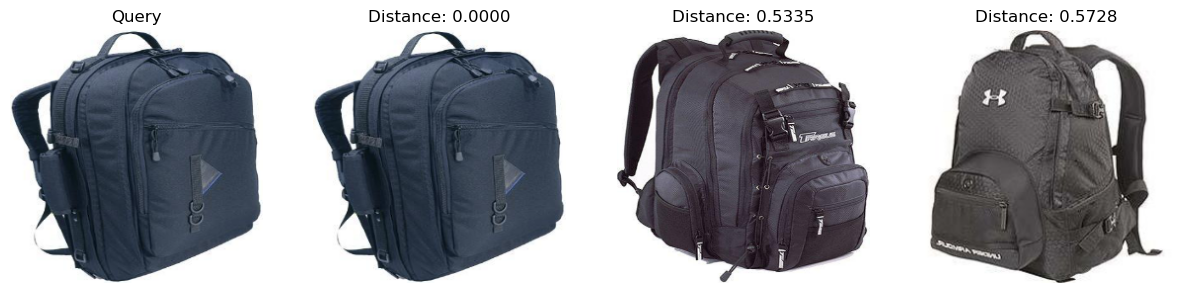

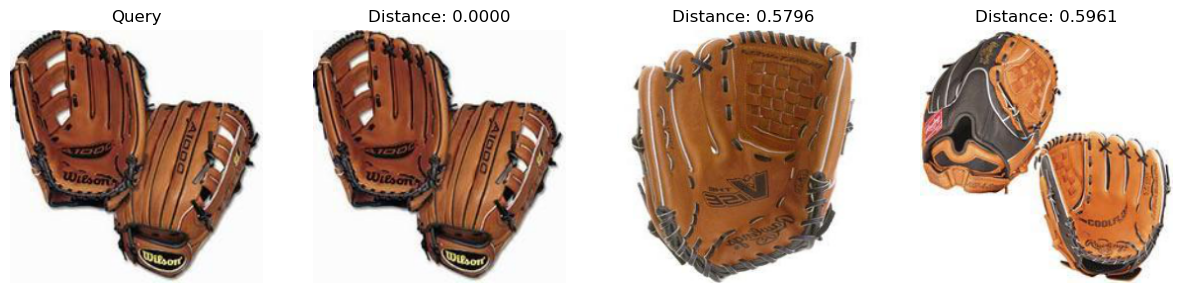

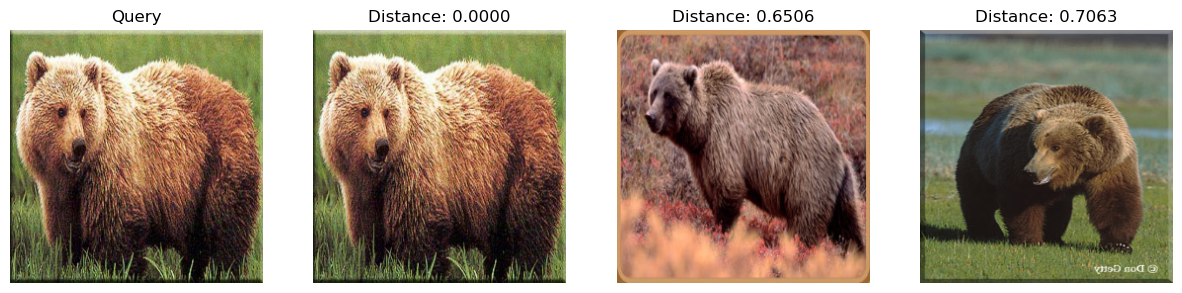

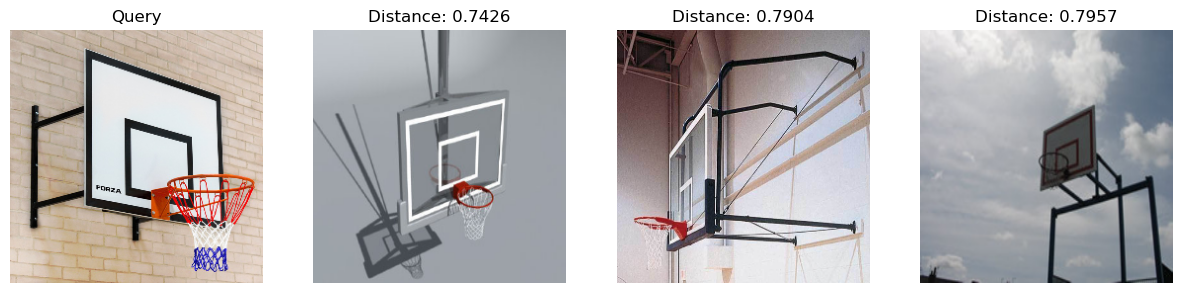

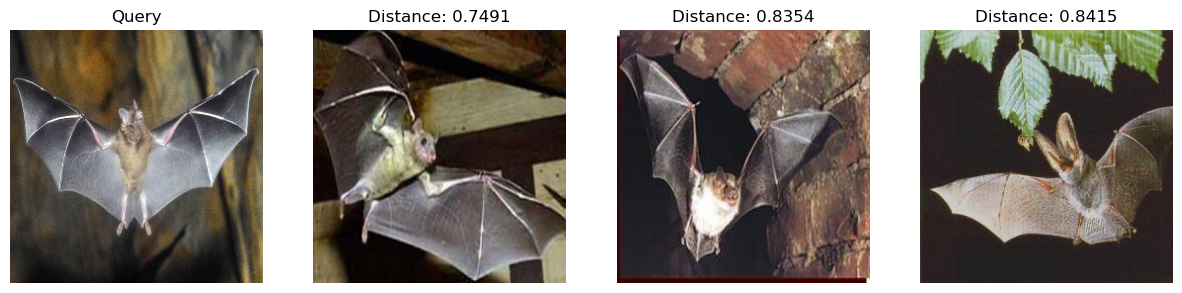

In [54]:
import matplotlib.pyplot as plt

embedding_dimensions = 2048
index = AnnoyIndex(embedding_dimensions, "angular") 
index.load("embeddings_resnet_index.ann")

query_folder = "Queries/*"
query_files = glob.glob(query_folder)

for query in query_files:
    print(query)
    img = read_image(query)
    embedding = embedding_model.predict(np.expand_dims(img, axis=0))[0]
    embedding = normalize(embedding.reshape(1, -1))[0]
    embedding = np.array(embedding)
    
    similar_image_indices, distances = index.get_nns_by_vector(embedding, 3, include_distances=True)

    match_1 = image_files[similar_image_indices[0]]
    match_2 = image_files[similar_image_indices[1]]
    match_3 = image_files[similar_image_indices[2]]

    
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title("Query")
    axes[0].axis("off")
    
    axes[1].imshow(read_image(match_1))
    axes[1].set_title(f"Distance: {distances[0]:.4f}")
    axes[1].axis("off")
    
    axes[2].imshow(read_image(match_2))
    axes[2].set_title(f"Distance: {distances[1]:.4f}")
    axes[2].axis("off")
    
    axes[3].imshow(read_image(match_3))
    axes[3].set_title(f"Distance: {distances[2]:.4f}")
    axes[3].axis("off")